#### <font color='silver'>Data Science Academy | Formação Ciência de Dados | Business Analytics | Roberto Soares</font>

# <font color='blue'>Marketing Analytics</font>
# <font color='blue'>Projeto de Segmentação de Clientes de Food Delivery</font>

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.9.13


## Iniciando o Desenvolvimento do Projeto

In [ ]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
!pip install -q -U watermark

### Carregando os Pacotes

In [2]:
# Imports

# Manipulação e visualização de dados
import time
import sklearn
import datetime
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib as m
import matplotlib.pyplot as plt

# Machine Learning
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

# Formatação dos gráficos
plt.style.use('fivethirtyeight')
plt.figure(1 , figsize = (15 , 6))
%matplotlib inline

In [ ]:
# Versões dos pacotes usados neste jupyter notebook
# %reload_ext watermark
# %watermark -a "rss-projetos" --iversions

In [ ]:
# Para instalar uma versão específica do Scikit-Learn, por exemplo:
#!pip install -q -U scikit-learn==0.23.1

### Carregando e Compreendendo os Dados

In [ ]:
#pip install chardet

In [3]:
import chardet

def verificar_encoding_arquivo(nome_arquivo):
    with open(nome_arquivo, 'rb') as f:
        enc = chardet.detect(f.read())
    return enc

In [4]:
file_path = "dados/dataset.csv"
file_enc = verificar_encoding_arquivo(file_path)
print(file_enc)

{'encoding': 'ascii', 'confidence': 1.0, 'language': ''}


In [5]:
# Carrega o dataset
df_food_delivery = pd.read_csv("dados/dataset.csv", 
                               #encoding = 'utf-8',
                               encoding = file_enc['encoding'],
                              )

In [6]:
# Shape
df_food_delivery.shape

(260645, 7)

In [7]:
# Visualiza os dados
df_food_delivery.head()

,id_transacao,horario_pedido,localidade,nome_item,quantidade_item,latitude,longitude
0,0x7901ee,2019-01-16 18:33:00,7,bebida,2,41.794132,-88.010140
1,0x7901ee,2019-01-16 18:33:00,7,pizza,2,41.794132,-88.010140
2,0x7901ee,2019-01-16 18:33:00,7,sobremesa,2,41.794132,-88.010140
3,0x12b47f,2019-09-04 12:36:00,3,salada,1,41.884490,-87.627059
4,0x12b47f,2019-09-04 12:36:00,3,sobremesa,1,41.884490,-87.627059


### Análise Exploratória

Vamos explorar os dados por diferentes perspectivas e compreender um pouco mais o relacionamento entre as variáveis.

In [8]:
# Verifica o total de valores únicos por coluna
df_food_delivery.nunique()

id_transacao       100000
horario_pedido      76799
localidade              9
nome_item               4
quantidade_item         5
latitude                9
longitude               9
dtype: int64

In [9]:
# Tipos de dados
df_food_delivery.dtypes

id_transacao        object
horario_pedido      object
localidade           int64
nome_item           object
quantidade_item      int64
latitude           float64
longitude          float64
dtype: object

In [10]:
# informação gerais
df_food_delivery.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260645 entries, 0 to 260644
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id_transacao     260645 non-null  object 
 1   horario_pedido   260645 non-null  object 
 2   localidade       260645 non-null  int64  
 3   nome_item        260645 non-null  object 
 4   quantidade_item  260645 non-null  int64  
 5   latitude         260645 non-null  float64
 6   longitude        260645 non-null  float64
dtypes: float64(2), int64(2), object(3)
memory usage: 58.9 MB


In [11]:
# Resumo das colunas numéricas
print(df_food_delivery.describe())

          localidade  quantidade_item       latitude      longitude
count  260645.000000    260645.000000  260645.000000  260645.000000
mean        5.134904         2.447010      41.836095     -87.733930
std         2.551846         1.330863       0.144459       0.136369
min         1.000000         1.000000      41.524598     -88.010140
25%         3.000000         1.000000      41.784576     -87.849468
50%         5.000000         2.000000      41.881818     -87.677606
75%         7.000000         4.000000      41.889047     -87.627059
max         9.000000         5.000000      42.049306     -87.607565


Começaremos criando uma tabela que nos fornecerá o número de vezes cada item foi solicitado em cada pedido.

In [12]:
# Lista para receber o total de pedidos
total_pedidos = []

Loop para criar a tabela pivot totalizando os itens por transação.

In [13]:
%%time

print("\nIniciando o agrupamento para o cálculo do total de pedidos. Seja paciente e aguarde...")

# Extraímos cada id e cada grupo do 'group by' por id_transacao
for k, group in df_food_delivery.groupby('id_transacao'):
    
    # Extraímos cada id e cada grupo do group by por horario_pedido
    for m, n in group.groupby('horario_pedido'):
        
        # Extraímos cada item de cada grupo
        id_transacao = k
        horario_pedido = m
        localidade = n['localidade'].values.tolist()[0]
        bebida = 0
        pizza = 0
        sobremesa = 0
        salada = 0
        n = n.reset_index(drop = True)
        
        # E então contabilizamos os itens pedidos
        for i in range(len(n)):
            item = n.loc[i, 'nome_item']
            num = n.loc[i, 'quantidade_item']
            
            if item == 'bebida':
                bebida = bebida + num
            
            elif item == 'pizza':
                pizza = pizza + num
            
            elif item == 'sobremesa':
                sobremesa = sobremesa + num
            
            elif item == 'salada':
                salada = salada + num
        
        output = [id_transacao, horario_pedido, localidade, bebida, pizza, sobremesa, salada]
        total_pedidos.append(output)
        
print("\nAgrupamento concluído!")


Iniciando o agrupamento para o cálculo do total de pedidos. Seja paciente e aguarde...

Agrupamento concluído!
Wall time: 1min 6s


In [14]:
# Convertemos a lista para dataframe
df_item_pedidos = pd.DataFrame(total_pedidos)

In [15]:
# Ajustamos os nomes das colunas
df_item_pedidos.columns = ['id_transacao', 'horario_pedido', 'localidade', 'bebida', 'pizza', 'sobremesa', 'salada']

In [16]:
# Shape
df_item_pedidos.shape

(100000, 7)

In [17]:
# Verifica o total de valores únicos por coluna
df_item_pedidos.nunique()

id_transacao      100000
horario_pedido     76799
localidade             9
bebida                 6
pizza                  6
sobremesa              5
salada                 6
dtype: int64

In [18]:
# Visualiza os dados originais
df_food_delivery.head()

,id_transacao,horario_pedido,localidade,nome_item,quantidade_item,latitude,longitude
0,0x7901ee,2019-01-16 18:33:00,7,bebida,2,41.794132,-88.010140
1,0x7901ee,2019-01-16 18:33:00,7,pizza,2,41.794132,-88.010140
2,0x7901ee,2019-01-16 18:33:00,7,sobremesa,2,41.794132,-88.010140
3,0x12b47f,2019-09-04 12:36:00,3,salada,1,41.884490,-87.627059
4,0x12b47f,2019-09-04 12:36:00,3,sobremesa,1,41.884490,-87.627059


In [19]:
# Visualiza o resultado do pivot
print(df_item_pedidos.head().to_string())

  id_transacao       horario_pedido  localidade  bebida  pizza  sobremesa  salada
0     0x10000a  2019-01-29 00:48:00           9       0      1          1       0
1     0x100058  2019-05-05 00:08:00           6       0      2          2       0
2     0x1000c8  2019-01-28 19:24:00           9       4      4          5       1
3     0x10014c  2019-02-23 00:15:00           6       0      1          1       0
4     0x1001d8  2019-06-30 17:50:00           2       3      3          3       0


Observe como uma simples mudança nos dados já oferece uma perspectiva completamente diferente dos dados. Na prática, o que fizemos foi criar uma tabela pivot.

**Será que temos uma forma mais simples de criar a tabela pivot? Sim.**

In [20]:
# Visualiza os dados originais
df_food_delivery.head()

,id_transacao,horario_pedido,localidade,nome_item,quantidade_item,latitude,longitude
0,0x7901ee,2019-01-16 18:33:00,7,bebida,2,41.794132,-88.010140
1,0x7901ee,2019-01-16 18:33:00,7,pizza,2,41.794132,-88.010140
2,0x7901ee,2019-01-16 18:33:00,7,sobremesa,2,41.794132,-88.010140
3,0x12b47f,2019-09-04 12:36:00,3,salada,1,41.884490,-87.627059
4,0x12b47f,2019-09-04 12:36:00,3,sobremesa,1,41.884490,-87.627059


In [21]:
# Shape
df_food_delivery.shape

(260645, 7)

In [22]:
# Visualiza os dados modificados
df_item_pedidos.head()

,id_transacao,horario_pedido,localidade,bebida,pizza,sobremesa,salada
0,0x10000a,2019-01-29 00:48:00,9,0,1,1,0
1,0x100058,2019-05-05 00:08:00,6,0,2,2,0
2,0x1000c8,2019-01-28 19:24:00,9,4,4,5,1
3,0x10014c,2019-02-23 00:15:00,6,0,1,1,0
4,0x1001d8,2019-06-30 17:50:00,2,3,3,3,0


In [23]:
# Shape
df_item_pedidos.shape

(100000, 7)

In [24]:
# Tipo do objeto
type(df_food_delivery)

pandas.core.frame.DataFrame

In [25]:
# Vamos criar uma tabela pivot com id_transacao, nome_item e quantidade_item
df_pivot = df_food_delivery.pivot_table(index = ['id_transacao'], columns = ['nome_item'], values = 'quantidade_item')

In [26]:
# Substituímos possíveis valores NA gerados no pivot, por 0 e transformamos o índice em coluna
df_pivot = df_pivot.fillna(0).reset_index()

In [27]:
# Tipo do objeto
type(df_pivot)

pandas.core.frame.DataFrame

In [28]:
# Tipos de dados nas colunas
df_pivot.dtypes

nome_item
id_transacao     object
bebida          float64
pizza           float64
salada          float64
sobremesa       float64
dtype: object

In [29]:
# Nomes das colunas
df_pivot.columns

Index(['id_transacao', 'bebida', 'pizza', 'salada', 'sobremesa'], dtype='object', name='nome_item')

In [30]:
# Visualiza os dados
print(df_pivot.head().to_string())

nome_item id_transacao  bebida  pizza  salada  sobremesa
0             0x10000a     0.0    1.0     0.0        1.0
1             0x100058     0.0    2.0     0.0        2.0
2             0x1000c8     4.0    4.0     1.0        5.0
3             0x10014c     0.0    1.0     0.0        1.0
4             0x1001d8     3.0    3.0     0.0        3.0


In [31]:
# Valores únicos
df_pivot.nunique()

nome_item
id_transacao    100000
bebida               6
pizza                6
salada               6
sobremesa            5
dtype: int64

In [32]:
# Shape
df_pivot.shape

(100000, 5)

In [33]:
# Describe
print(df_pivot.describe())

nome_item         bebida          pizza         salada      sobremesa
count      100000.000000  100000.000000  100000.000000  100000.000000
mean            1.239590       1.857840       0.711370       2.569210
std             1.627886       1.588589       1.086524       1.332084
min             0.000000       0.000000       0.000000       1.000000
25%             0.000000       1.000000       0.000000       1.000000
50%             0.000000       1.000000       0.000000       2.000000
75%             3.000000       3.000000       1.000000       4.000000
max             5.000000       5.000000       5.000000       5.000000


In [34]:
# Não podemos ter valores nulos
df_pivot.isnull().sum()

nome_item
id_transacao    0
bebida          0
pizza           0
salada          0
sobremesa       0
dtype: int64

In [35]:
# Vamos incluir a coluna localidade e para fazer o merge precisamos de uma coluna em comum, nesse caso, id_transacao
df_pivot2 = df_pivot.merge(df_food_delivery[['id_transacao', 'localidade','latitude','longitude']])

In [36]:
df_pivot2.drop_duplicates(subset=None, keep='first', inplace=True, ignore_index=True)

In [37]:
# Visualiza os dados
df_pivot2.head()

,id_transacao,bebida,pizza,salada,sobremesa,localidade,latitude,longitude
0,0x10000a,0.0,1.0,0.0,1.0,9,41.524598,-87.849468
1,0x100058,0.0,2.0,0.0,2.0,6,41.784576,-87.607565
2,0x1000c8,4.0,4.0,1.0,5.0,9,41.524598,-87.849468
3,0x10014c,0.0,1.0,0.0,1.0,6,41.784576,-87.607565
4,0x1001d8,3.0,3.0,0.0,3.0,2,42.049306,-87.677606


In [38]:
# Shape
df_pivot2.nunique()

id_transacao    100000
bebida               6
pizza                6
salada               6
sobremesa            5
localidade           9
latitude             9
longitude            9
dtype: int64

### Extraindo Granularidade de Tempo

A coluna de horário do pedido tem detalhes como mês, dia e ano. Em algum momento pode ser interessante fazer a segmentação por mês, por exemplo. Vamos então extrair o mês e colocar em uma coluna separada.

In [39]:
# Visualiza os dados
df_item_pedidos.head(3)

,id_transacao,horario_pedido,localidade,bebida,pizza,sobremesa,salada
0,0x10000a,2019-01-29 00:48:00,9,0,1,1,0
1,0x100058,2019-05-05 00:08:00,6,0,2,2,0
2,0x1000c8,2019-01-28 19:24:00,9,4,4,5,1


In [40]:
# Extraímos o mês da coluna horario_pedido e gravamos em uma nova coluna
df_item_pedidos['ano'] = df_item_pedidos['horario_pedido'].apply(lambda x: time.strftime("%Y", time.strptime(x,"%Y-%m-%d %H:%M:%S")))
df_item_pedidos['mes'] = df_item_pedidos['horario_pedido'].apply(lambda x: time.strftime("%m", time.strptime(x,"%Y-%m-%d %H:%M:%S")))


In [41]:
# Visualiza o resultado
print(df_item_pedidos.head(10).to_string())

  id_transacao       horario_pedido  localidade  bebida  pizza  sobremesa  salada   ano mes
0     0x10000a  2019-01-29 00:48:00           9       0      1          1       0  2019  01
1     0x100058  2019-05-05 00:08:00           6       0      2          2       0  2019  05
2     0x1000c8  2019-01-28 19:24:00           9       4      4          5       1  2019  01
3     0x10014c  2019-02-23 00:15:00           6       0      1          1       0  2019  02
4     0x1001d8  2019-06-30 17:50:00           2       3      3          3       0  2019  06
5     0x1002af  2019-12-28 17:25:00           9       3      3          4       1  2019  12
6     0x10034c  2019-03-12 18:17:00           5       3      4          4       0  2019  03
7     0x100378  2019-10-13 18:44:00           4       4      4          5       1  2019  10
8     0x100391  2019-10-10 18:07:00           5       4      4          4       0  2019  10
9     0x1003a9  2019-06-23 00:39:00           6       0      2          2       

In [42]:
# Vamos incluir a coluna localidade e para fazer o merge precisamos de uma coluna em comum, nesse caso, id_transacao
df_pivot = df_pivot.merge(df_item_pedidos[['id_transacao', 'mes']])

In [43]:
# Visualiza o resultado
df_pivot.head(10)

,id_transacao,bebida,pizza,salada,sobremesa,mes
0,0x10000a,0.0,1.0,0.0,1.0,01
1,0x100058,0.0,2.0,0.0,2.0,05
2,0x1000c8,4.0,4.0,1.0,5.0,01
3,0x10014c,0.0,1.0,0.0,1.0,02
4,0x1001d8,3.0,3.0,0.0,3.0,06
5,0x1002af,3.0,3.0,1.0,4.0,12
6,0x10034c,3.0,4.0,0.0,4.0,03
7,0x100378,4.0,4.0,1.0,5.0,10
8,0x100391,4.0,4.0,0.0,4.0,10
9,0x1003a9,0.0,2.0,0.0,2.0,06


In [44]:
# Visualiza valores únicos
df_pivot.nunique()

id_transacao    100000
bebida               6
pizza                6
salada               6
sobremesa            5
mes                 12
dtype: int64

### Ajuste de Índices

Para segmentar os pedidos dos clientes, precisamos de uma coluna de identificação de cada registro. Não podemos usar id_transacao, pois essa coluna representa um dado válido e além disso não é um valor único, logo não pode ser usado como índice.

Vamos então criar uma coluna usando o índice atual, o que acha? Vamos checar o índice:

In [45]:
# Dataset
df_item_pedidos

,id_transacao,horario_pedido,localidade,bebida,pizza,sobremesa,salada,ano,mes
0,0x10000a,2019-01-29 00:48:00,9,0,1,1,0,2019,01
1,0x100058,2019-05-05 00:08:00,6,0,2,2,0,2019,05
2,0x1000c8,2019-01-28 19:24:00,9,4,4,5,1,2019,01
3,0x10014c,2019-02-23 00:15:00,6,0,1,1,0,2019,02
4,0x1001d8,2019-06-30 17:50:00,2,3,3,3,0,2019,06
...,...,...,...,...,...,...,...,...,...
99995,0xffe96,2019-01-05 19:28:00,4,4,4,4,0,2019,01
99996,0xffeed,2019-08-08 00:42:00,2,0,1,1,0,2019,08
99997,0xfff07,2019-05-04 00:48:00,2,1,1,1,0,2019,05
99998,0xfff4d,2019-07-18 00:17:00,3,0,2,2,0,2019,07


In [46]:
# Índice
df_item_pedidos.index

RangeIndex(start=0, stop=100000, step=1)

In [47]:
# Fazemos o reset no índice e gravamos o resultado em outro dataframe
df_item_pedidos_idx = df_item_pedidos.reset_index()

In [48]:
# Pronto, agora temos uma coluna de ID com valor único para cada registro
df_item_pedidos_idx.head()

,index,id_transacao,horario_pedido,localidade,bebida,pizza,sobremesa,salada,ano,mes
0,0,0x10000a,2019-01-29 00:48:00,9,0,1,1,0,2019,01
1,1,0x100058,2019-05-05 00:08:00,6,0,2,2,0,2019,05
2,2,0x1000c8,2019-01-28 19:24:00,9,4,4,5,1,2019,01
3,3,0x10014c,2019-02-23 00:15:00,6,0,1,1,0,2019,02
4,4,0x1001d8,2019-06-30 17:50:00,2,3,3,3,0,2019,06


In [49]:
# Dataset
df_item_pedidos

,id_transacao,horario_pedido,localidade,bebida,pizza,sobremesa,salada,ano,mes
0,0x10000a,2019-01-29 00:48:00,9,0,1,1,0,2019,01
1,0x100058,2019-05-05 00:08:00,6,0,2,2,0,2019,05
2,0x1000c8,2019-01-28 19:24:00,9,4,4,5,1,2019,01
3,0x10014c,2019-02-23 00:15:00,6,0,1,1,0,2019,02
4,0x1001d8,2019-06-30 17:50:00,2,3,3,3,0,2019,06
...,...,...,...,...,...,...,...,...,...
99995,0xffe96,2019-01-05 19:28:00,4,4,4,4,0,2019,01
99996,0xffeed,2019-08-08 00:42:00,2,0,1,1,0,2019,08
99997,0xfff07,2019-05-04 00:48:00,2,1,1,1,0,2019,05
99998,0xfff4d,2019-07-18 00:17:00,3,0,2,2,0,2019,07


### Análise Descritiva

### Distplot dos Atributos Usados Para Segmentação

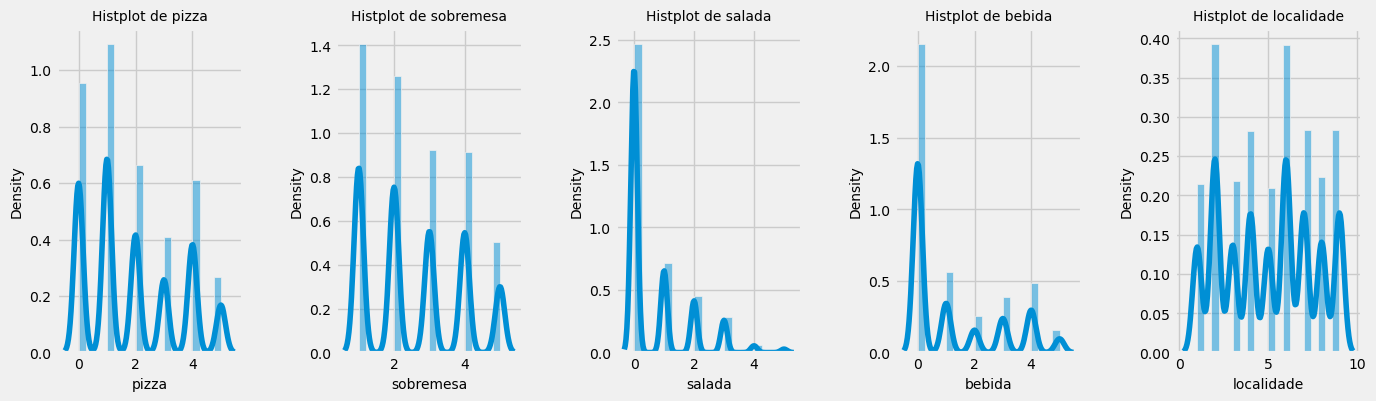

In [50]:
# Plot

# Tamanho da figura
plt.figure(1 , figsize = (15 , 4))

# Inicializa o contador
n = 0 

# Loop pelas colunas
for x in ['pizza' , 'sobremesa' , 'salada', 'bebida', 'localidade']:
    n += 1
    plt.subplot(1 , 5 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    #sns.distplot(df_item_pedidos[x] , bins = 20)
    sns.histplot(df_item_pedidos[x], bins=20, stat="density", kde=True ,kde_kws=dict(cut=3))  # Use kde=True se desejar uma estimativa de densidade
                                                                                              # Observe como a curva do KDE ultrapassa o histograma no distplot, mas cobre apenas o intervalo real dos dados no histplot. 
                                                                                              # Este comportamento pode ser controlado com o parâmetro cut, que você precisa passar usando o kde_kws. 
                                                                                              # O padrão do histplot é 0, enquanto o padrão do distplot é 3 (as unidades são múltiplos da largura de banda do kernel).
  
    # Ajuste o tamanho da fonte do título
    plt.title('Histplot de {}'.format(x), fontsize=10)
    
    # Ajuste o tamanho da fonte do eixo x
    plt.xlabel(x, fontsize=10)
    
    # Ajuste o tamanho da fonte do eixo x
    plt.ylabel("Density", fontsize=10)
   
    # Ajuste o tamanho dos valores nos eixos x e y
    plt.tick_params(axis='both', which='both', labelsize=10)
    
plt.show()

### Gráfico de Total de Pedidos Por Localidade

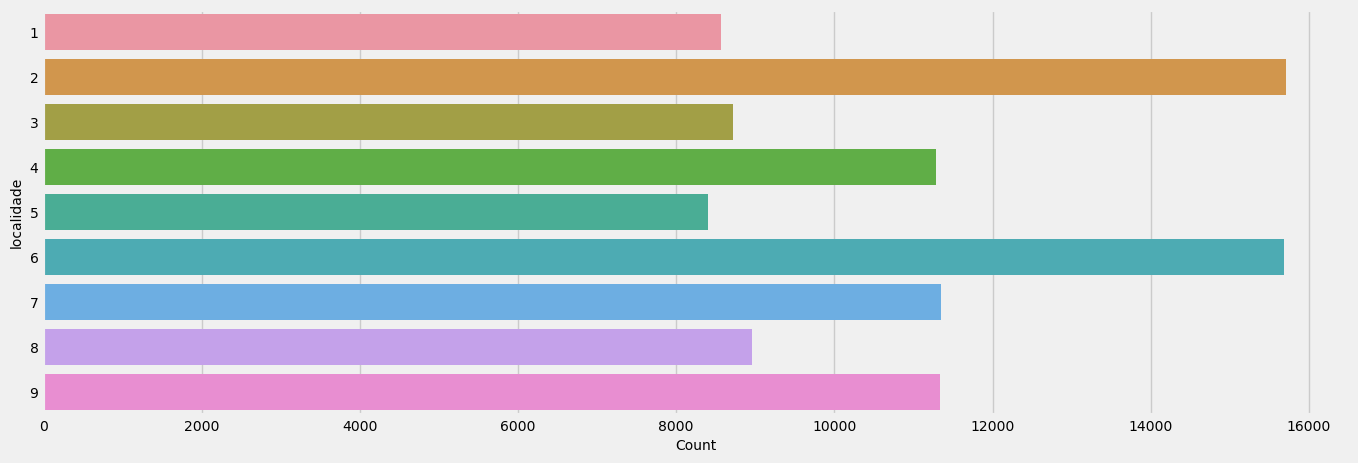

In [51]:
# Plot
plt.figure(1 , figsize = (15 , 5))
sns.countplot(y = 'localidade' , data = df_item_pedidos)
# Ajuste o tamanho da fonte do eixo x
plt.xlabel('Count', fontsize=10)
# Ajuste o tamanho da fonte do eixo y
plt.ylabel('localidade' , fontsize=10)
# Ajuste o tamanho dos valores nos eixos x e y
plt.tick_params(axis='both', which='both', labelsize=10)
plt.show()

### Regplot dos Atributos Usados Para Segmentação

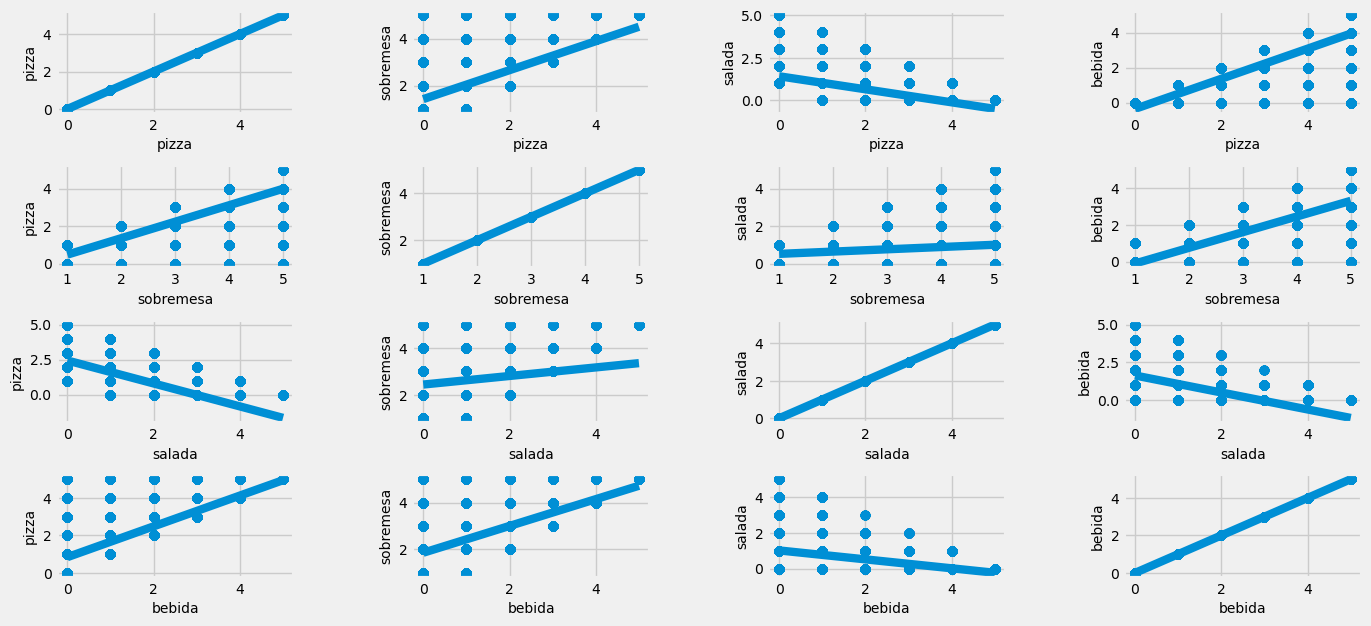

In [52]:
# Relação Entre os Atributos

# Tamanho da figura
plt.figure(1 , figsize = (15 , 7))

# Inicializa o contador
n = 0 

# Loop pelos atributos
for x in ['pizza' , 'sobremesa' , 'salada', 'bebida']:
    for y in ['pizza' , 'sobremesa' , 'salada', 'bebida']:
        n += 1
        plt.subplot(4 , 4 , n)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
        sns.regplot(x = x , y = y , data = df_item_pedidos)
        #plt.ylabel(y)
        # Ajuste o tamanho da fonte do eixo x
        plt.xlabel(x, fontsize=10)
        # Ajuste o tamanho da fonte do eixo y
        plt.ylabel(y, fontsize=10)
        # Ajuste o tamanho dos valores nos eixos x e y
        plt.tick_params(axis='both', which='both', labelsize=10)
plt.show()

### Definindo as Variáveis Para Segmentação

Vamos remover id_transacao, horario_pedido, localidade e mes para nossas primeiras atividades de clusterização.

In [53]:
# Filtrando o dataframe por colunas 
df_item_pedidos_idx[['index', 'bebida', 'pizza', 'sobremesa', 'salada']]

,index,bebida,pizza,sobremesa,salada
0,0,0,1,1,0
1,1,0,2,2,0
2,2,4,4,5,1
3,3,0,1,1,0
4,4,3,3,3,0
...,...,...,...,...,...
99995,99995,4,4,4,0
99996,99996,0,1,1,0
99997,99997,1,1,1,0
99998,99998,0,2,2,0


In [54]:
# Vamos gerar um novo dataframe com o slice anterior
df = df_item_pedidos_idx[['index', 'bebida', 'pizza', 'sobremesa', 'salada']]

In [55]:
# Dataset
df.head()

,index,bebida,pizza,sobremesa,salada
0,0,0,1,1,0
1,1,0,2,2,0
2,2,4,4,5,1
3,3,0,1,1,0
4,4,3,3,3,0


Perfeito. Podemos avançar.

### Análise de Cluster

Clusterização é um processo de aprendizagem não supervisionada, quando entregamos a um algoritmo de Machine Learning somente os dados de entrada e durante o treinamento, o algoritmo cria um modelo capaz de gerar saídas, nesse caso grupos, ou clusters.

### Métricas de Clusterização - Definição e Interpretação

Está disponível no manual em pdf no próximo item de aprendizagem.

### Segmentação 1

Vamos realizar nossa primeira segmentação usando 2 variáveis.

#### Segmentação 1 - Definindo o Número de Atributos


Usando 2 Variáveis (Pizza e Sobremesa).

In [ ]:
# Usaremos duas variáveis
X1 = df[['pizza' , 'sobremesa']].iloc[: , :].values

In [ ]:
# Lista do WCSS
wcss_X1 = []

Muitas vezes, os dados com os quais você trabalha têm várias dimensões, dificultando a visualização. Como consequência, o número ideal de clusters não é muito óbvio. Felizmente, temos uma maneira de determinar isso matematicamente.

Representamos graficamente a relação entre o número de clusters e a soma dos quadrados dentro do cluster (Within Cluster Sum of Squares - WCSS) e, em seguida, selecionamos o número de clusters nos quais a mudança no WCSS começa a se estabilizar (Método Elbow).

#### Segmentação 1 - Encontrando o Valor Ideal de Clusters

Vamos testar diferentes valores de K (valores de cluster) entre 2 e 10.

Para a inicialização dos clusters, usamos o algoritmo k-means++ que oferece convergência mais rápida para o resultado final.

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

In [ ]:
# Loop para testar os valores de K
for n in range(2, 11):
    modelo = (KMeans(n_clusters = n,
                     init = 'k-means++', 
                     n_init = 10,
                     max_iter = 300, 
                     tol = 0.0001,  
                     random_state = 111, 
                     algorithm = 'elkan'))
    modelo.fit(X1)
    wcss_X1.append(modelo.inertia_)

In [ ]:
# Plot
plt.figure(1 , figsize = (15 ,6))
plt.plot(np.arange(2 , 11) , wcss_X1 , 'o')
plt.plot(np.arange(2 , 11) , wcss_X1 , '-' , alpha = 0.5)
plt.xlabel('Número de Clusters') , plt.ylabel('WCSS')
plt.show()

Escolhemos o valor ideal de clusters e criamos o modelo final para a Segmentação 1. Observe no gráfico acima que não há certo ou errado. Poderíamos trabalhar com qualquer valor entre 2 e 10 (não faz sentido criar apenas 1 cluster).

O gráfico acima é chamado de Curva de Elbow e normalmente usamos o valor com o menor WCSS. Mas isso deve ser alinhado com as necessidade de negócio. Para esse exemplo, não faria sentido usar 10 clusters. Vamos começar com 2 clusters e avaliar e interpretar os resultados.

#### Segmentação 1 - Construindo e Treinando o Modelo

In [ ]:
# Criação do modelo
modelo_seg1 = KMeans(n_clusters = 2, 
                     init = 'k-means++', 
                     n_init = 10, 
                     max_iter = 300, 
                     tol = 0.0001,  
                     random_state = 111, 
                     algorithm = 'elkan')

In [ ]:
# Treinamento do modelo
modelo_seg1.fit(X1)

In [ ]:
# Extração dos labels
labels1 = modelo_seg1.labels_
labels1

In [ ]:
# Extração dos centróides
centroids1 = modelo_seg1.cluster_centers_
centroids1

Caso queira alterar a combinação de cores dos gráficos, basta alterar a paleta usada. Aqui estão as opções:

https://matplotlib.org/3.2.0/tutorials/colors/colormaps.html

Para o Segmento 1 estamos usando plt.cm.Set2.

#### Segmentação 1 - Visualização e Interpretação dos Segmentos

In [ ]:
# Plot

# Parâmetros do Meshgrid
h = 0.02
x_min, x_max = X1[:, 0].min() - 1, X1[:, 0].max() + 1
y_min, y_max = X1[:, 1].min() - 1, X1[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = modelo_seg1.predict(np.c_[xx.ravel(), yy.ravel()]) 
plt.figure(1 , figsize = (15, 7) )
plt.clf()
Z = Z.reshape(xx.shape)

# Plot da imagem
plt.imshow(Z, 
           interpolation = 'nearest', 
           extent = (xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Set2, 
           aspect = 'auto', 
           origin = 'lower')

# Plot dos pontos de dados
plt.scatter( x = 'pizza', y = 'sobremesa', data = df, c = labels1, s = 200 )
plt.scatter(x = centroids1[: , 0], y =  centroids1[: , 1], s = 300, c = 'red', alpha = 0.5)
plt.xlabel('Pizza')
plt.ylabel('Sobremesa')
plt.show()

**Interpretação**: 

- O ponto vermelho é o centróide de cada cluster (segmento).


- No cluster 1 (área em verde) temos os clientes que pediram 0, 1 ou 2 Pizzas. Em todos os casos houve pedido de Sobremesa.


- No cluster 2 (área em cinza) estão clientes que pediram 2, 3, 4 ou 5 Pizzas. Perceba que à medida que o pedido tem maior número de Pizzas, também aumenta o número de Sobremesas.

**Análise**:

- Cluster 1 - Clientes que pedem menos Pizzas. Todos pedem sobremesa.

- Cluster 2 - Clientes que pedem mais Pizzas. Todos pedem sobremesa em volume maior.

Como estratégia de Marketing, poderíamos oferecer ao cliente uma sobremesa grátis no caso de comprar mais uma Pizza de maior valor. Com base na Segmentação provavelmente essa estratégia teria sucesso.

----------------

Vamos criar mais 4 Segmentações:

- Segmentação 2 - Variáveis Pizza e Salada
- Segmentação 3 - Variáveis Pizza e Localidade
- Segmentação 4 - Variáveis Pizza, Salada e Localidade
- Segmentação 5 - Variáveis Pizza, Salada e Sobremesa

### Segmentação 2

Segmentação 2 - Variáveis Pizza e Salada

In [ ]:
# Usaremos duas variáveis
X1 = df[['pizza' , 'salada']].iloc[: , :].values

# Lista de valores de Inertia (Inertia e WCSS são a mesma coisa)
inertia = []

# Loop para testar os valores de K
for n in range(2 , 11):
    modelo = (KMeans(n_clusters = n,
                     init = 'k-means++', 
                     n_init = 10,
                     max_iter = 300, 
                     tol = 0.0001,  
                     random_state = 111, 
                     algorithm = 'elkan'))
    modelo.fit(X1)
    inertia.append(modelo.inertia_)

# Plot
plt.figure(1 , figsize = (15 ,6))
plt.plot(np.arange(2 , 11) , inertia , 'o')
plt.plot(np.arange(2 , 11) , inertia , '-' , alpha = 0.5)
plt.xlabel('Número de Clusters') , plt.ylabel('Inertia')
plt.show()

Vamos criar o modelo com 3 clusters.

In [ ]:
# Criação do modelo com 3 clusters
modelo_seg2 = (KMeans(n_clusters = 3,
                      init = 'k-means++', 
                      n_init = 10 ,
                      max_iter = 300, 
                      tol = 0.0001,  
                      random_state = 111  , 
                      algorithm = 'elkan') )

# Treinamento do modelo
modelo_seg2.fit(X1)

# Labels
labels2 = modelo_seg2.labels_

# Centróides
centroids2 = modelo_seg2.cluster_centers_

In [ ]:
# Plot

# Parâmetros do Meshgrid
h = 0.02
x_min, x_max = X1[:, 0].min() - 1, X1[:, 0].max() + 1
y_min, y_max = X1[:, 1].min() - 1, X1[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = modelo_seg2.predict(np.c_[xx.ravel(), yy.ravel()]) 
plt.figure(1 , figsize = (15, 7) )
plt.clf()
Z = Z.reshape(xx.shape)

# Plot da imagem
plt.imshow(Z, 
           interpolation = 'nearest', 
           extent = (xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Dark2, 
           aspect = 'auto', 
           origin = 'lower')

# Plot dos pontos de dados
plt.scatter( x = 'pizza', y = 'salada', data = df, c = labels2, s = 200 )
plt.scatter(x = centroids2[: , 0], y =  centroids2[: , 1], s = 300, c = 'red', alpha = 0.5)
plt.xlabel('Pizza')
plt.ylabel('Salada')
plt.show()

**Interpretação**: 

- O ponto vermelho é o centróide de cada cluster (segmento).


- No cluster 1 (área em cinza) temos os clientes que pediram menos Pizzas e mais Saladas.


- No cluster 2 (área em verde escuro) temos os clientes que pediram poucas Pizzas e poucas Saladas.


- No cluster 3 (área em verde claro) estão clientes que pediram mais Pizzas e menos Saladas.

**Análise**:

Os clusters 1 e 3 são de clientes com comportamentos opostos. A equipe de Marketing poderia concentrar os esforços nos clientes do cluster 2, pois são clientes que compram Pizzas e Saladas e, portanto, tendem a consumir mais itens variados evitando manter os estoques cheios de um único item. 

Ou então, concentrar os esforços nos clientes que consomem produtos que geram mais lucro. Teríamos que verificar qual item, Pizza ou Salada, é mais rentável.

### Segmentação 3

Segmentação 3 - Variáveis Pizza e Localidade

In [ ]:
# Filtrando o dataframe por colunas 
df_item_pedidos_idx[['index', 'bebida', 'pizza', 'sobremesa', 'salada', 'localidade']]

In [ ]:
# Criando um novo dataframe
df2 = df_item_pedidos_idx[['index', 'bebida', 'pizza', 'sobremesa', 'salada', 'localidade']]

In [ ]:
# Resumo do dataset
df2.describe()

In [ ]:
# Usaremos duas variáveis
X1 = df2[['pizza' , 'localidade']].iloc[: , :].values

# Lista de valores de Inertia (Inertia e WCSS são a mesma coisa)
inertia = []

# Loop para testar os valores de K
for n in range(2 , 11):
    modelo = (KMeans(n_clusters = n,
                     init = 'k-means++', 
                     n_init = 10,
                     max_iter = 300, 
                     tol = 0.0001,  
                     random_state = 111, 
                     algorithm = 'elkan'))
    modelo.fit(X1)
    inertia.append(modelo.inertia_)

# Plot
plt.figure(1 , figsize = (15 ,6))
plt.plot(np.arange(2 , 11) , inertia , 'o')
plt.plot(np.arange(2 , 11) , inertia , '-' , alpha = 0.5)
plt.xlabel('Número de Clusters') , plt.ylabel('Inertia')
plt.show()

Vamos criar o modelo com 4 clusters.

In [ ]:
# Criação do modelo com 4 clusters
modelo_seg3 = (KMeans(n_clusters = 4,
                      init = 'k-means++', 
                      n_init = 10 ,
                      max_iter = 300, 
                      tol = 0.0001,  
                      random_state = 111  , 
                      algorithm = 'elkan') )

# Treinamento do modelo
modelo_seg3.fit(X1)

# Labels
labels3 = modelo_seg3.labels_

# Centróides
centroids3 = modelo_seg3.cluster_centers_

In [ ]:
# Plot

# Parâmetros do Meshgrid
h = 0.02
x_min, x_max = X1[:, 0].min() - 1, X1[:, 0].max() + 1
y_min, y_max = X1[:, 1].min() - 1, X1[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = modelo_seg3.predict(np.c_[xx.ravel(), yy.ravel()]) 
plt.figure(1 , figsize = (15, 7) )
plt.clf()
Z = Z.reshape(xx.shape)

# Plot da imagem
plt.imshow(Z, 
           interpolation = 'nearest', 
           extent = (xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Pastel1, 
           aspect = 'auto', 
           origin = 'lower')

# Plot dos pontos de dados
plt.scatter( x = 'pizza', y = 'localidade', data = df2, c = labels3, s = 200 )
plt.scatter(x = centroids3[: , 0], y =  centroids3[: , 1], s = 300, c = 'red', alpha = 0.5)
plt.xlabel('Pizza')
plt.ylabel('Localidade')
plt.show()

**Interpretação**: 

- O ponto vermelho é o centróide de cada cluster (segmento).


- Observe que os clusters da esquerda no gráfico contém os pedidos de todas as Localidades, mas com menor número de Pizzas. Já os clusters da direita no gráfico contém pedidos de todas as Localidades com com maior número de Pizzas.

**Análise**:

Queremos aumentar as vendas, certo? Então teríamos que investigar mais a fundo os pedidos dos clusters à esquerda do gráfico e compreender em mais detalhes as características desses pedidos e que tipo de oferta podemos fazer.

### Segmentação 4

Segmentação 4 - Variáveis Pizza, Salada e Localidade

In [ ]:
# Usaremos três variáveis
X1 = df2[['pizza' , 'salada' , 'localidade']].iloc[: , :].values

# Lista de valores de Inertia (Inertia e WCSS são a mesma coisa)
inertia = []

# Loop para testar os valores de K
for n in range(2 , 11):
    modelo = (KMeans(n_clusters = n,
                     init = 'k-means++', 
                     n_init = 10,
                     max_iter = 300, 
                     tol = 0.0001,  
                     random_state = 111, 
                     algorithm = 'elkan'))
    modelo.fit(X1)
    inertia.append(modelo.inertia_)

# Plot
plt.figure(1 , figsize = (15 ,6))
plt.plot(np.arange(2 , 11) , inertia , 'o')
plt.plot(np.arange(2 , 11) , inertia , '-' , alpha = 0.5)
plt.xlabel('Número de Clusters') , plt.ylabel('Inertia')
plt.show()

Vamos criar o modelo com 4 clusters.

In [ ]:
# Criação do modelo com 4 clusters
modelo_seg4 = (KMeans(n_clusters = 4,
                      init = 'k-means++', 
                      n_init = 10 ,
                      max_iter = 300, 
                      tol = 0.0001,  
                      random_state = 111  , 
                      algorithm = 'elkan') )

# Treinamento do modelo
modelo_seg4.fit(X1)

# Labels
labels4 = modelo_seg4.labels_

# Centróides
centroids4 = modelo_seg4.cluster_centers_

O Meshgrid que criamos até aqui é útil para duas dimensões, mas com 3 dimensões precisamos de um gráfico mais apropriado. Um Scatter3d.

In [ ]:
# Instala o Plotly
!pip install -q plotly

In [ ]:
# Pacotes para o gráfico 3D
import plotly as py
import plotly.graph_objs as go
py.offline.init_notebook_mode(connected = True)

In [ ]:
# Versões dos pacotes usados neste jupyter notebook
#%reload_ext watermark
#%watermark -a "Data Science Academy" --iversions

In [ ]:
# Plot

# Gráfico 3D
grafico = go.Scatter3d(x = df2['pizza'], 
                       y = df2['salada'], 
                       z = df2['localidade'], 
                       mode = 'markers', 
                       marker = dict(color = labels4, 
                                     size = 4,
                                     line = dict(color = labels4, width = 15),
                                     opacity = 0.7))

# Layout do gráfico
layout = go.Layout(title = 'Clusters',
                   scene = dict(xaxis = dict(title  = 'Pizza'),
                                yaxis = dict(title  = 'Salada'),
                                zaxis = dict(title  = 'Localidade')))

# Plot da figura (gráfico + layout)
fig = go.Figure(data = grafico, layout = layout)
py.offline.iplot(fig)

In [ ]:
# Importe as bibliotecas necessárias
import plotly.graph_objs as go
import plotly.offline as py
import pandas as pd

# Supondo que 'labels4' seja a coluna que contém as cores
#labels4 = df2['labels4']

# Gráfico 2D (Dispersão)
grafico = go.Scatter(x=df2['pizza'],
                    y=df2['salada'],
                    mode='markers',
                    marker=dict(color=labels4,
                                size=8,
                                colorscale='Viridis',  # Pode alterar a escala de cores conforme necessário
                                colorbar=dict(title='Clusters'),
                                opacity=0.7))

# Layout do gráfico
layout = go.Layout(title='Clusters',
                   xaxis=dict(title='Pizza'),
                   yaxis=dict(title='Salada'))

# Plot da figura (gráfico + layout)
fig = go.Figure(data=[grafico], layout=layout)
py.iplot(fig)


**Interpretação**: 

- Observamos 2 clusters inferiores e 2 superiores.


- Cada ponto de dado representa uma coordenada de 3 dimensões.

**Análise**:

Aqui o ideal é avaliar o gráfico de forma interativa aproveitando essa propriedade do Plotly.

### Segmentação 5

Segmentação 5 - Variáveis Pizza, Salada e Sobremesa

In [ ]:
# Usaremos três variáveis
X1 = df2[['pizza' , 'salada' , 'sobremesa']].iloc[: , :].values

# Lista de valores de Inertia (Inertia e WCSS são a mesma coisa)
inertia = []

# Loop para testar os valores de K
for n in range(2 , 11):
    modelo = (KMeans(n_clusters = n,
                     init = 'k-means++', 
                     n_init = 10,
                     max_iter = 300, 
                     tol = 0.0001,  
                     random_state = 111, 
                     algorithm = 'elkan'))
    modelo.fit(X1)
    inertia.append(modelo.inertia_)

# Plot
plt.figure(1 , figsize = (15 ,6))
plt.plot(np.arange(2 , 11) , inertia , 'o')
plt.plot(np.arange(2 , 11) , inertia , '-' , alpha = 0.5)
plt.xlabel('Número de Clusters') , plt.ylabel('Inertia')
plt.show()

Vamos criar o modelo com 2 clusters.

In [ ]:
# Criação do modelo com 2 clusters
modelo_seg5 = (KMeans(n_clusters = 2,
                      init = 'k-means++', 
                      n_init = 10 ,
                      max_iter = 300, 
                      tol = 0.0001,  
                      random_state = 111  , 
                      algorithm = 'elkan') )

# Treinamento do modelo
modelo_seg5.fit(X1)

# Labels
labels5 = modelo_seg5.labels_

# Centróides
centroids5 = modelo_seg5.cluster_centers_

In [ ]:
# Plot

# Gráfico 3D
grafico = go.Scatter3d(x = df2['pizza'], 
                       y = df2['salada'], 
                       z = df2['sobremesa'], 
                       mode = 'markers', 
                       marker = dict(color = labels5, 
                                     size = 4,
                                     line = dict(color = labels5, width = 15),
                                     opacity = 0.7))

# Layout do gráfico
layout = go.Layout(title = 'Clusters',
                   scene = dict(xaxis = dict(title  = 'Pizza'),
                                yaxis = dict(title  = 'Salada'),
                                zaxis = dict(title  = 'Sobremesa')))

# Plot da figura (gráfico + layout)
fig = go.Figure(data = grafico, layout = layout)
py.offline.iplot(fig)

**Interpretação**: 

- Observamos a clara separação entre os dados dois 2 clusters.


- Cada ponto de dado representa uma coordenada de 3 dimensões.

**Análise**:

Aqui o ideal é avaliar o gráfico de forma interativa aproveitando essa propriedade do Plotly.

**Exemplo de Relatório final (Considerando a Segmentação 5)**

In [ ]:
# Shape dos labels
labels5.shape

In [ ]:
# Tipo
type(labels5)

In [ ]:
# Converte o array para dataframe
df_labels = pd.DataFrame(labels5)

In [ ]:
# Visualiza
df_labels.head(5)

In [ ]:
# Tipo
type(df_labels)

In [ ]:
# Vamos fazer o merge de df2 e os labels (clusters) encontrados pelo modelo
# Lembre-se que usamos somente 3 variáveis para criar a segmentação
df_final = df2.merge(df_labels, left_index = True, right_index = True)

In [ ]:
# Visualiza
df_final

In [ ]:
# Ajusta o nome da coluna
df_final.rename(columns = {0:"cluster"}, inplace = True)

In [ ]:
# Visualiza
df_final

---------

Agora é com você! Faça modificações nos hiperparâmetros do modelo, use diferentes números de clusters, compare os resultados e gere um relatório final para a área de negócio.

# Fim 